In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

In [2]:
input_train_path = os.path.join(
    '..',
    'dataset',
    'feature-engineering',
    'iteration-1.csv'
)

df_train = pd.read_csv(input_train_path)
df_train.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability_mainly_not_orderable,availability_mainly_orderable,address_-99,address_1,address_2,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,onlineStatus_-99,onlineStatus_0
0,1,6.0,5.0,0.000,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,6.0,5.0,11.940,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6.0,5.0,39.887,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,6.0,5.0,0.000,0.0,-99.00,-99.00,-99.00,0.0,-99.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,6.0,5.0,15.633,0.0,-99.00,-99.00,-99.00,0.0,-99.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train.iloc[0]

sessionNo                                         1
startHour                                       6.0
startWeekday                                    5.0
duration                                        0.0
cCount                                          1.0
cMinPrice                                     59.99
cMaxPrice                                     59.99
cSumPrice                                     59.99
bCount                                          1.0
bMinPrice                                     59.99
bMaxPrice                                     59.99
bSumPrice                                     59.99
bStep                                         -99.0
onlineStatus                                    -99
availability                                    -99
customerNo                                      1.0
maxVal                                        600.0
customerScore                                  70.0
accountLifetime                                21.0
payments    

# Prepare training and test set

In [4]:
## remove redundant features - we've done one hot encoding
df_train.drop(
    labels=["availability", "address", "time_of_day", "onlineStatus"], 
    axis=1,
    inplace=True
)

In [5]:
## train test split (using original data, without handling imbalanced class distribution)
from sklearn.model_selection import train_test_split

TEST_PROPORTION = 0.3
RND = 121
target_class = 'order'
features = df_train.columns[(df_train.columns != target_class)]

X_train, X_test, y_train, y_test = train_test_split(
    df_train[features], 
    df_train[target_class],
    test_size=TEST_PROPORTION,
    random_state=RND
)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(300309, 35) (300309,)
(128704, 35) (128704,)


In [7]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print(f"Accuracy : {accuracy:.3%}")
        print(f"F1-score : {f_score:.3%}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_true, y_pred))
        
    return accuracy, f_score, auc

In [8]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape=k)
    cv_f1 = np.zeros(shape=k)
    cv_auc = np.zeros(shape=k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, f_score, auc = evaluate_performance(y_val, y_pred, print_results = False)
        print(f"Iteration {i+1}: Accuracy={accuracy:.3%} | F1-score={f_score:.3%} | AUC={auc:.3%}")
        
        cv_accuracy[i] = accuracy
        cv_f1[i] = f_score
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print(f"Accuracy: {np.mean(cv_accuracy):.3%} +- {np.std(cv_accuracy):.3%}")
    print(f"F1-score: {np.mean(cv_f1):.3%} +- {np.std(cv_f1):.3%}")
    print(f"AUC: {np.mean(cv_auc):.3f} +- {np.std(cv_auc):.3f}")

# Model Training and Evaluation

## Baseline: Logistic Regression without fine-tuning

In [9]:
from sklearn.linear_model import LogisticRegression

model_logres = LogisticRegression(random_state=RND, max_iter=200, solver='saga', penalty='elasticnet', l1_ratio=0.2)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_logres, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_logres.fit(X_train, y_train)

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 1: Accuracy=71.869% | F1-score=80.176% | AUC=65.172%


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 2: Accuracy=71.626% | F1-score=80.029% | AUC=64.887%


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 3: Accuracy=71.766% | F1-score=80.151% | AUC=64.956%


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 4: Accuracy=71.388% | F1-score=79.866% | AUC=64.569%


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 5: Accuracy=71.702% | F1-score=80.108% | AUC=64.876%
Cross-validation results
Accuracy: 71.670% +- 0.162%
F1-score: 80.066% +- 0.112%
AUC: 0.649 +- 0.002


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.2, max_iter=200, penalty='elasticnet',
                   random_state=121, solver='saga')

In [10]:
y_pred = model_logres.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 71.481%
F1-score : 79.903%
AUC: 0.647
              precision    recall  f1-score   support

           0       0.58      0.45      0.51     41947
           1       0.76      0.84      0.80     86757

    accuracy                           0.71    128704
   macro avg       0.67      0.65      0.65    128704
weighted avg       0.70      0.71      0.70    128704



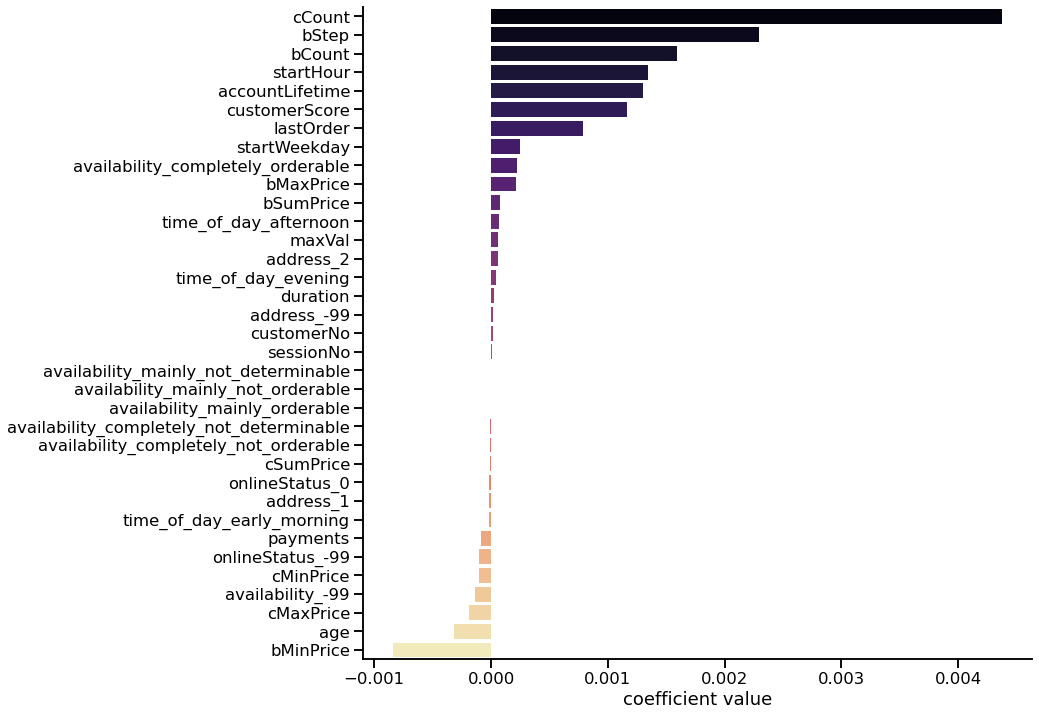

In [12]:
logres_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_logres.coef_[0]
    }
).sort_values(by='coef', ascending=False)
logres_coef['coef_abs'] = np.abs(logres_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data = logres_coef,
    y = 'feature_name',
    x = 'coef',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();